#### Predictions with Logistic regression. 

Using the sakila DB, we're trying to figure out which movies will be rented the next month.

In [1]:
!pip install imblearn

In [2]:
import imblearn
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
password = getpass.getpass()

········


In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query = '''

with rented_movies_past_month as (
	select  distinct film_id, rental_id, rental_date
	from film
	join inventory using(film_id)
	join rental using(inventory_id)
	where substr(rental_date, 1, 7) = '2006-02'
	order by film_id asc
)
select film_id, rental_duration, rental_rate, length, replacement_cost, rating, if (film_id in (
											select film_id from rented_movies_past_month
                                            ), True, False) as rented_last_month
from film 
join inventory i using(film_id)
join rental r using(inventory_id)
group by film_id, title;

'''

data = pd.read_sql_query(query, engine)
data

,film_id,rental_duration,rental_rate,length,replacement_cost,rating,rented_last_month
0,1,6,0.99,86,20.99,PG,0
1,2,3,4.99,48,12.99,G,1
2,3,7,2.99,50,18.99,NC-17,0
3,4,5,2.99,117,26.99,G,1
4,5,6,2.99,130,22.99,G,1
...,...,...,...,...,...,...,...
953,996,6,0.99,183,9.99,G,0
954,997,4,0.99,179,14.99,NC-17,0
955,998,6,0.99,105,10.99,NC-17,1
956,999,5,2.99,101,28.99,R,0


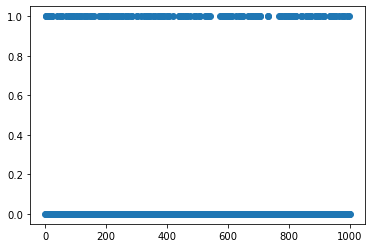

In [4]:
plt.scatter(data['film_id'], data['rented_last_month'])
plt.show()

In [5]:
data = data.set_index('film_id')
data

,rental_duration,rental_rate,length,replacement_cost,rating,rented_last_month
film_id,,,,,,
1,6,0.99,86,20.99,PG,0
2,3,4.99,48,12.99,G,1
3,7,2.99,50,18.99,NC-17,0
4,5,2.99,117,26.99,G,1
5,6,2.99,130,22.99,G,1
...,...,...,...,...,...,...
996,6,0.99,183,9.99,G,0
997,4,0.99,179,14.99,NC-17,0
998,6,0.99,105,10.99,NC-17,1


In [6]:
data.dtypes

rental_duration        int64
rental_rate          float64
length                 int64
replacement_cost     float64
rating                object
rented_last_month      int64
dtype: object

In [7]:
data.describe()

,rental_duration,rental_rate,length,replacement_cost,rented_last_month
count,958.000000,958.000000,958.000000,958.000000,958.000000
mean,4.969729,2.977474,115.490605,20.059937,0.175365
std,1.407593,1.643152,40.471844,6.059985,0.380478
min,3.000000,0.990000,46.000000,9.990000,0.000000
25%,4.000000,0.990000,80.250000,14.990000,0.000000
50%,5.000000,2.990000,114.000000,19.990000,0.000000
75%,6.000000,4.990000,150.000000,24.990000,0.000000
max,7.000000,4.990000,185.000000,29.990000,1.000000


In [8]:
# Checking the NaNs - none!
data.isna().sum()

rental_duration      0
rental_rate          0
length               0
replacement_cost     0
rating               0
rented_last_month    0
dtype: int64

In [9]:
# Quite balanced rental_rates
# I should probably treat them as categoricals
data['rental_rate'].value_counts()

0.99    326
4.99    320
2.99    312
Name: rental_rate, dtype: int64

In [10]:
# Checking the ratings
# Also quite balanced
data['rating'].value_counts()

PG-13    213
NC-17    202
R        189
PG       183
G        171
Name: rating, dtype: int64

In [11]:
# Transforming rental_rate, I think it might be better use it as a categorical
data['rental_rate'] = data['rental_rate'].astype('object')
data['rental_rate']

film_id
1       0.99
2       4.99
3       2.99
4       2.99
5       2.99
        ... 
996     0.99
997     0.99
998     0.99
999     2.99
1000    4.99
Name: rental_rate, Length: 958, dtype: object

In [12]:
X = pd.get_dummies(data.drop('rented_last_month', axis=1))
# DO NOT dummify the target variable
y = data['rented_last_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [13]:
model = LogisticRegression(random_state=42, max_iter=100000)
model.fit(X_train, y_train) # Training the model

LogisticRegression(max_iter=100000, random_state=42)

In [14]:
predictions = model.predict(X_test)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
print(classification_report(y_test, predictions))

model.score(X_test, y_test)

# score is not too bas, but the model still doesn't predict any ones
# # Looks like the model is not good in predicting Ones

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       166
           1       0.00      0.00      0.00        26

    accuracy                           0.86       192
   macro avg       0.43      0.50      0.46       192
weighted avg       0.75      0.86      0.80       192



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8645833333333334

In [24]:
# model.predict_proba(X_test)


#### Some EDA

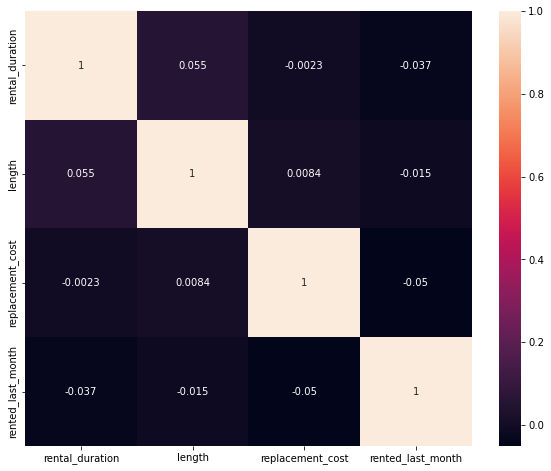

In [16]:
# No Columns having a high correlation with each other

corr_matrix=data.corr(method='pearson') 
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

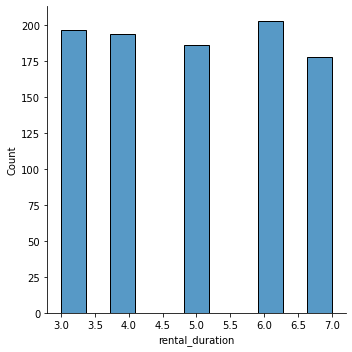

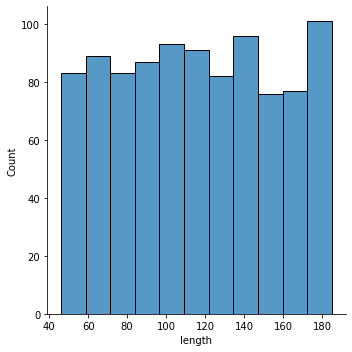

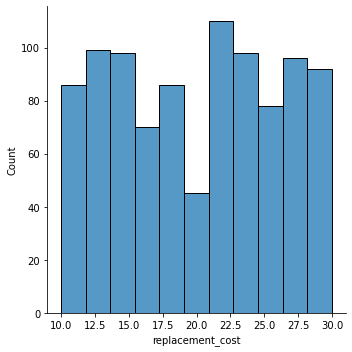

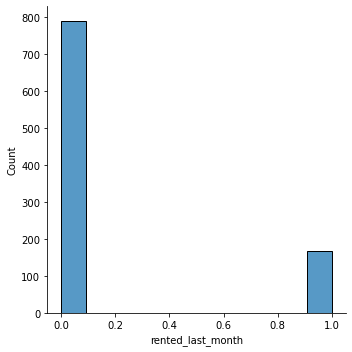

In [17]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()
    
# Rental Duration has many separated values
# Length and Replacement cost have also not normalized curves
# rented_last_month of course not, because it has only 0's and 1's

In [18]:
# I cannot use any scaler (I need at least two classes in the data) but am not sure which columns can contribute 
# to the ML algorithm to predict if a movie will be rented next month or not - would much appreciate any suggestions :) 